# Transfer Learning and Fine Tuning a pre-trained Deep CNN on a GPU

This session is inspired by [a blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) by François Chollet, the creator of the Keras library.

**WARNING**: the execution of notebook **requires a powerful GPU** (e.g. nvidia K80, GTX 980 or later with a least 6GB of GPU RAM).


For this session we are going to use the dataset of the [dogs-vs-cats](https://www.kaggle.com/c/dogs-vs-cats/data).

If you use the pre-built Azure VM image (recommended) the **data has already been downloaded**.

To download the data yourself, create a password-based account on Kaggle, then click on the download link of one of the data file **when you are logged-in in your browser** to get to the form that makes you accept the terms and conditions of that challenge.

Then in a shell session possibly on a server do the following:

```bash
pip install kaggle-cli
mkdir -p ~/data/dogs-vs-cats
cd ~/data/dogs-vs-cats
kg download -u username -p password -c dogs-vs-cats
```

This should download 3 files among which: `train.zip` and `test1.zip` (and a CSV template file we won't need).

Once this is done **we can extract the archives for the train set**:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import os
import os.path as op
import shutil
from zipfile import ZipFile

data_folder = op.expanduser('~/data/dogs-vs-cats')
train_folder = op.join(data_folder, 'train')

if not op.exists(train_folder):
    train_zip = op.join(data_folder, 'train.zip')
    print('Extracting %s...' % train_zip)
    ZipFile(train_zip).extractall(data_folder)

The Keras image data helpers want images for different classes ('cat' and 'dog') to live in distinct subfolders. Let's rearrange the image files to follow that convention:

In [2]:
def rearrange_folders(folder):
    image_filenames = [op.join(folder, fn) for fn in os.listdir(folder)
                       if fn.endswith('.jpg')]
    if len(image_filenames) == 0:
        return
    print("Rearranging %d images in %s into one subfolder per class..."
          % (len(image_filenames), folder))
    for image_filename in image_filenames:
        subfolder, _ = image_filename.split('.', 1)
        subfolder = op.join(folder, subfolder)
        if not op.exists(subfolder):
            os.mkdir(subfolder)
        shutil.move(image_filename, subfolder)


rearrange_folders(train_folder)

Lets build a validation dataset by taking 500 images of cats and 500 images of dogs out of the training set:

In [3]:
n_validation = 500

validation_folder = op.join(data_folder, 'validation')
if not op.exists(validation_folder):
    os.mkdir(validation_folder)
    for class_name in ['dog', 'cat']:
        train_subfolder = op.join(train_folder, class_name)
        validation_subfolder = op.join(validation_folder, class_name)
        print("Populating %s..." % validation_subfolder)
        os.mkdir(validation_subfolder)
        images_filenames = sorted(os.listdir(train_subfolder))
        for image_filename in images_filenames[-n_validation:]:
            shutil.move(op.join(train_subfolder, image_filename),
                        validation_subfolder)
        print("Moved %d images" % len(os.listdir(validation_subfolder)))

## Loading a pre-trained computer vision model

Let us load a state of the art model with a good tradeoff between prediction speed, model size and predictive accuracy, namely a Residual Network with 54 parameterized layers (53 convolutional + 1 fully connected for the softmax):

In [4]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.applications.resnet50 import ResNet50, preprocess_input

full_imagenet_model = ResNet50(weights='imagenet')

Using TensorFlow backend.


In [5]:
print(full_imagenet_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

If you have `graphviz` system package and the `pydot_ng` python package installed you can uncomment the following cell to display the structure of the network.

## Transfer learning



### Transfer learning step 1: truncate a pretrain model

Let's remove the last dense classification layer that is specific to the image net classes and use the previous layer (after flattening) as a feature extractor:

In [6]:
from keras.models import Model

output = full_imagenet_model.layers[-2].output
base_model = Model(full_imagenet_model.input, output)

In [7]:
len(full_imagenet_model.layers)

176

In [8]:
len(base_model.layers)

175

### Transfer learning step 2: extract features with the pretrained model

We now use JPEG files from a smaller labeled datasets with only cats and dogs:

In [9]:
train_folder

'/home/experience1004/data/dogs-vs-cats/train'

In [10]:
!ls -lh $train_folder

total 1.0M
drwxrwxr-x 2 experience1004 experience1004 508K Oct  2 14:33 cat
drwxrwxr-x 2 experience1004 experience1004 508K Oct  2 14:33 dog


In [11]:
!ls -lh $train_folder/cat

total 263M
-rw-rw-r-- 1 experience1004 experience1004  13K Oct  2 14:33 cat.0.jpg
-rw-rw-r-- 1 experience1004 experience1004  22K Oct  2 14:33 cat.10000.jpg
-rw-rw-r-- 1 experience1004 experience1004  27K Oct  2 14:33 cat.10001.jpg
-rw-rw-r-- 1 experience1004 experience1004  26K Oct  2 14:33 cat.10002.jpg
-rw-rw-r-- 1 experience1004 experience1004  28K Oct  2 14:33 cat.10003.jpg
-rw-rw-r-- 1 experience1004 experience1004  13K Oct  2 14:33 cat.10004.jpg
-rw-rw-r-- 1 experience1004 experience1004 8.1K Oct  2 14:33 cat.10005.jpg
-rw-rw-r-- 1 experience1004 experience1004  24K Oct  2 14:33 cat.10006.jpg
-rw-rw-r-- 1 experience1004 experience1004  11K Oct  2 14:33 cat.10007.jpg
-rw-rw-r-- 1 experience1004 experience1004  25K Oct  2 14:33 cat.10008.jpg
-rw-rw-r-- 1 experience1004 experience1004  21K Oct  2 14:33 cat.10009.jpg
-rw-rw-r-- 1 experience1004 experience1004 5.9K Oct  2 14:33 cat.1000.jpg
-rw-rw-r-- 1 experience1004 experience1004  33K Oct  2 14:33 cat.10010.jpg
-rw-rw-r-- 1 experi

When using this model we need to be careful to apply the same image processing as was used during the training, otherwise the marginal distribution of the input pixels might not be on the right scale:

In [12]:
def preprocess_function(x):
    if x.ndim == 3:
        x = x[np.newaxis, :, :, :]
    return preprocess_input(x)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 50

datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

train_flow = datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

X, y = next(train_flow)
print(X.shape, y.shape)

Found 24000 images belonging to 2 classes.
(50, 224, 224, 3) (50,)


Iterate of over a subset of 2000 images in the training set (bach after batch), extracts the activations of the last layer of `base_model` (by calling predicts) and collect the results in a big numpy array with dimensions `(2000, 2048)` for the features and `(2000,)` for the matching image labels.

In [14]:
from time import time

features = []
labels = []

count = 0
for X, y in train_flow:
    labels.append(y)
    t0 = time()
    features.append(base_model.predict(X))
    delta = time() - t0
    count += len(y)
    if count % 100 == 0:
        print("processed %d images (%d images/s)"
              % (count, len(y) / delta))
    if count >= 2000:
        break
        
features_train = np.vstack(features)
labels_train = np.concatenate(labels)

processed 100 images (88 images/s)
processed 200 images (92 images/s)
processed 300 images (92 images/s)
processed 400 images (92 images/s)
processed 500 images (91 images/s)
processed 600 images (92 images/s)
processed 700 images (91 images/s)
processed 800 images (92 images/s)
processed 900 images (92 images/s)
processed 1000 images (93 images/s)
processed 1100 images (91 images/s)
processed 1200 images (91 images/s)
processed 1300 images (92 images/s)
processed 1400 images (89 images/s)
processed 1500 images (91 images/s)
processed 1600 images (92 images/s)
processed 1700 images (92 images/s)
processed 1800 images (93 images/s)
processed 1900 images (92 images/s)
processed 2000 images (92 images/s)


Let's train a simple linear model on those features. First let's check that the resulting small dataset has balanced classes:

In [15]:
n_samples, n_features = features_train.shape
print("{:d} features extracted for {:d} images"
      .format(n_features, n_samples))

2048 features extracted for 2000 images


In [16]:
print(labels_train.shape)

(2000,)


In [17]:
np.mean(labels_train)

0.509

### Transfer learning step 3: train a classification model on the extracted features

Let's define the classification model:

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam


top_model = Sequential()
top_model.add(Dense(1, input_dim=n_features, activation='sigmoid'))
top_model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

top_model.fit(features_train, labels_train,
              validation_split=0.1, verbose=2, epochs=15)

Train on 1800 samples, validate on 200 samples
Epoch 1/15
0s - loss: 0.7307 - acc: 0.5633 - val_loss: 0.5407 - val_acc: 0.7400
Epoch 2/15
0s - loss: 0.4275 - acc: 0.8383 - val_loss: 0.3378 - val_acc: 0.9050
Epoch 3/15
0s - loss: 0.2881 - acc: 0.9306 - val_loss: 0.2376 - val_acc: 0.9500
Epoch 4/15
0s - loss: 0.2149 - acc: 0.9561 - val_loss: 0.1807 - val_acc: 0.9750
Epoch 5/15
0s - loss: 0.1722 - acc: 0.9689 - val_loss: 0.1461 - val_acc: 0.9800
Epoch 6/15
0s - loss: 0.1446 - acc: 0.9728 - val_loss: 0.1217 - val_acc: 0.9800
Epoch 7/15
0s - loss: 0.1253 - acc: 0.9756 - val_loss: 0.1052 - val_acc: 0.9800
Epoch 8/15
0s - loss: 0.1110 - acc: 0.9778 - val_loss: 0.0925 - val_acc: 0.9800
Epoch 9/15
0s - loss: 0.1003 - acc: 0.9794 - val_loss: 0.0836 - val_acc: 0.9850
Epoch 10/15
0s - loss: 0.0914 - acc: 0.9822 - val_loss: 0.0745 - val_acc: 0.9850
Epoch 11/15
0s - loss: 0.0840 - acc: 0.9822 - val_loss: 0.0685 - val_acc: 0.9850
Epoch 12/15
0s - loss: 0.0781 - acc: 0.9839 - val_loss: 0.0633 - val_ac

Alright so the transfer learning is already at ~0.98 / 0.99 accuracy. This is not too surprising as the cats and dogs classes are already part of the imagenet label set.

Note that this is **already as good or slightly better than the winner of the original kaggle competition** [three years ago](https://www.kaggle.com/c/dogs-vs-cats/leaderboard). At that time they did not have pretrained resnet models at hand.

Or validation set has 1000 images, so an accuracy of 0.990 means only 10 classification errors.

Let's plug this on top the base model to be able to use it to make some classifications on our held out validation image folder:

### Transfer learning step 4: assemble the truncated pre-trained model with its new head

This way we can apply the new model to new JPEG files not part of the cats-vs-dogs training set

In [19]:
model = Model(base_model.input, top_model(base_model.output))

### Transfer learning step 5: evaluate on new test images

Found 1000 images belonging to 2 classes.


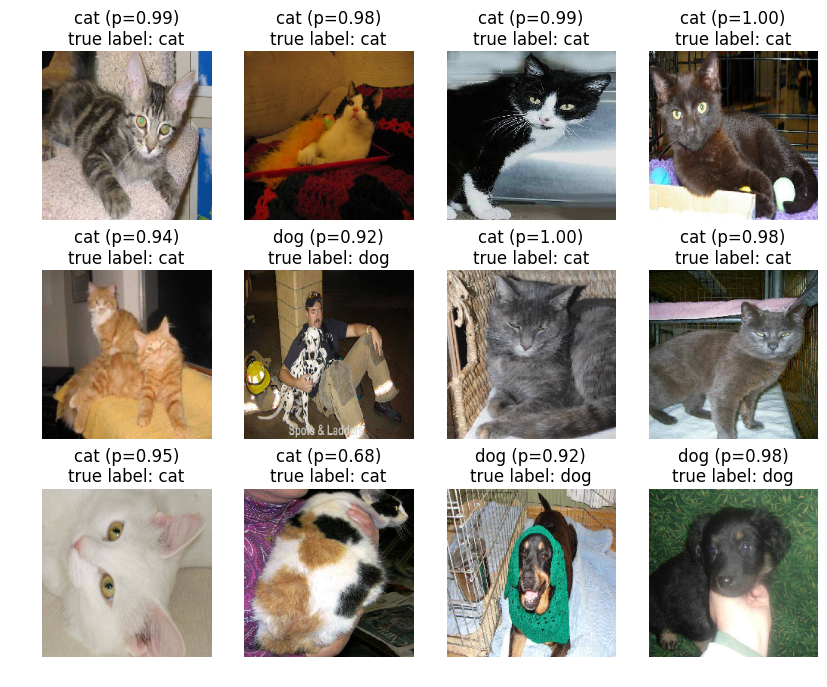

In [32]:
flow = ImageDataGenerator().flow_from_directory(
    validation_folder, batch_size=1, target_size=(224, 224),
    shuffle=True, class_mode='binary')

plt.figure(figsize=(10, 8))
for i, (X, y) in zip(range(12), flow):
    plt.subplot(3, 4, i + 1)
    pred = model.predict(preprocess_input(X.copy()))[0]
    pred_label = "dog" if pred > 0.5 else "cat"
    pred_prob = pred if pred_label == "dog" else (1 - pred)
    label = "dog" if y > 0.5 else "cat"
    plt.imshow(X[0] / 255)
    plt.title("%s (p=%0.2f)\ntrue label: %s"
              % (pred_label, pred_prob, label))
    plt.axis('off')

Let's compute the validation score on the full validation set:

In [21]:
val_flow = ImageDataGenerator().flow_from_directory(
    validation_folder, batch_size=batch_size,
    target_size=(224, 224), shuffle=False,
    class_mode='binary')

all_correct = []
image_batches = []
prediction_batches = []
label_batches = []
for i, (X, y) in zip(range(val_flow.n // val_flow.batch_size), val_flow):
    predictions = model.predict(preprocess_input(X.copy())).ravel()
    correct = list((predictions > 0.5) == y)
    image_batches.append(X)
    prediction_batches.append(predictions)
    label_batches.append(y)
    all_correct.extend(correct)
    print("Processed %d images" % len(all_correct))
    
print("\nValidation accuracy: %0.4f" % np.mean(all_correct))

Found 1000 images belonging to 2 classes.
Processed 50 images
Processed 100 images
Processed 150 images
Processed 200 images
Processed 250 images
Processed 300 images
Processed 350 images
Processed 400 images
Processed 450 images
Processed 500 images
Processed 550 images
Processed 600 images
Processed 650 images
Processed 700 images
Processed 750 images
Processed 800 images
Processed 850 images
Processed 900 images
Processed 950 images
Processed 1000 images

Validation accuracy: 0.9810


### Let's have a look at the worst classification errors

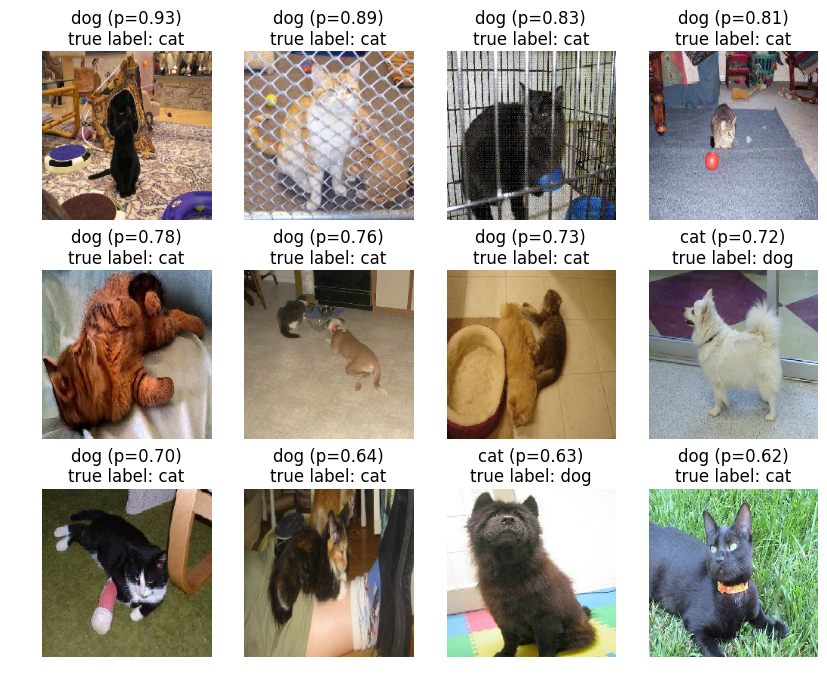

In [33]:
images = np.vstack(image_batches)
predictions = np.concatenate(prediction_batches)
labels = np.concatenate(label_batches)

worst = np.abs(predictions - labels).argsort()[::-1][:15]
images, predictions, labels = images[worst], predictions[worst], labels[worst]

plt.figure(figsize=(10, 8))
for i, image, label, pred in zip(range(12), images, labels, predictions):
    plt.subplot(3, 4, i + 1)
    plt.imshow(image / 255)
    pred_label = "dog" if pred > 0.5 else "cat"
    pred_prob = pred if pred_label == "dog" else (1 - pred)
    label = "dog" if label > 0.5 else "cat"
    plt.title("%s (p=%0.2f)\ntrue label: %s"
              % (pred_label, pred_prob, label))
    plt.axis('off')

## Data Loading and Data Augmentation


Let's use keras utilities to manually load the first image file of the cat folder. If keras complains about the missing "PIL" library, make sure to install it with one of the following commands:

```bash
conda install pillow

# or

pip install pillow
```

You might need to restart the kernel of this notebook to get Keras work.

In [23]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

img = load_img(op.join(train_folder, 'cat', 'cat.249.jpg'))
x = img_to_array(img)

print(x.shape)

(336, 344, 3)


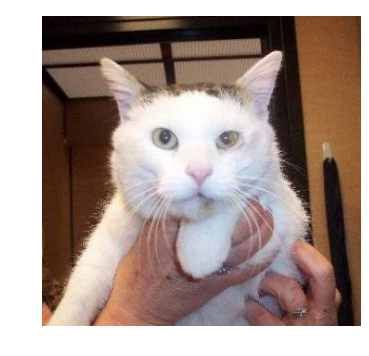

In [24]:
plt.imshow(x / 255)
plt.axis('off');

Keras provides tools to generate many variations from a single image: this is useful to augment the dataset with variants that should not affect the image label: a rotated image of a cat is an image of a cat.

Doing data augmentation at train time make neural networks ignore such label-preserving transformations and therefore help reduce overfitting.

In [25]:
from keras.preprocessing.image import ImageDataGenerator


augmenting_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=9,
    fill_mode='nearest'
)

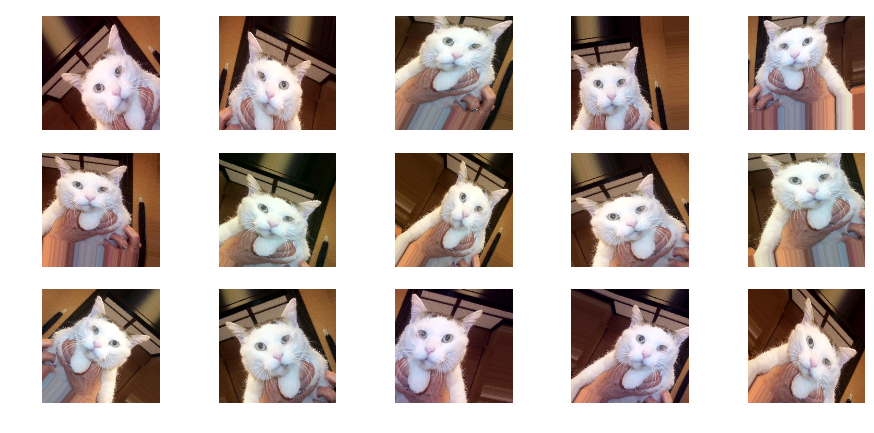

In [26]:
plt.figure(figsize=(11, 5))
flow = augmenting_datagen.flow(x[np.newaxis, :, :, :])
for i, x_augmented in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_augmented[0])
    plt.axis('off')

The `ImageDataGenerator` object can the be pointed to the dataset folder both load the image and augment them on the fly and resize / crop them to fit the input dimensions of the classification neural network.

Found 24000 images belonging to 2 classes.


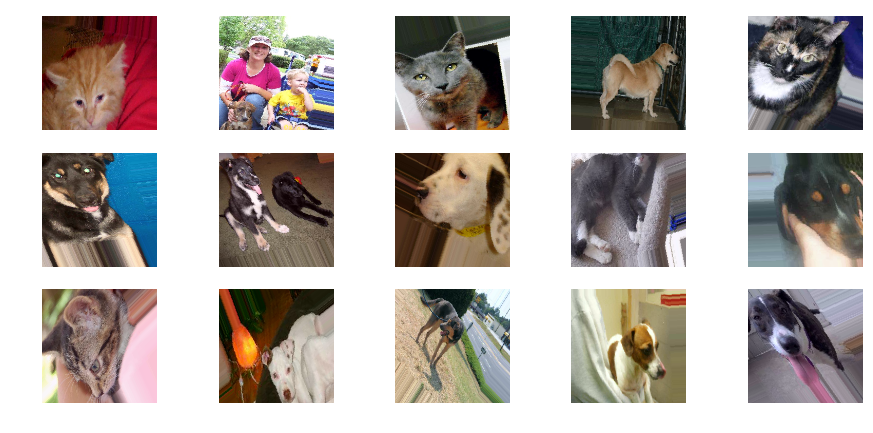

In [27]:
flow = augmenting_datagen.flow_from_directory(
    train_folder, batch_size=1, target_size=(224, 224))

plt.figure(figsize=(11, 5))
for i, (X, y) in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X[0])
    plt.axis('off')

## Fine tuning

Let's identify the location of the residual blocks (merge by addition in a residual architecture):

In [28]:
from keras.layers.merge import Add

[(i, l.output_shape)
 for (i, l) in enumerate(model.layers)
 if isinstance(l, Add)]

[(15, (None, 55, 55, 256)),
 (25, (None, 55, 55, 256)),
 (35, (None, 55, 55, 256)),
 (47, (None, 28, 28, 512)),
 (57, (None, 28, 28, 512)),
 (67, (None, 28, 28, 512)),
 (77, (None, 28, 28, 512)),
 (89, (None, 14, 14, 1024)),
 (99, (None, 14, 14, 1024)),
 (109, (None, 14, 14, 1024)),
 (119, (None, 14, 14, 1024)),
 (129, (None, 14, 14, 1024)),
 (139, (None, 14, 14, 1024)),
 (151, (None, 7, 7, 2048)),
 (161, (None, 7, 7, 2048)),
 (171, (None, 7, 7, 2048))]

Let's fix the weights of the low level layers and fine tune the top level layers:

In [29]:
for i, layer in enumerate(model.layers):
    layer.trainable = i >= 152

Let's fine tune a bit the top level layers to see if we can further improve the accuracy. Use the **nvidia-smi** command in a bash terminal on the server to monitor the GPU usage when the model is training.

In [ ]:
from keras import optimizers

augmenting_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_function,
)
train_flow = augmenting_datagen.flow_from_directory(
    train_folder, target_size=(224, 224), batch_size=batch_size,
    class_mode='binary', shuffle=True, seed=0)

opt = optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy',
              metrics=['accuracy'])


# compute the validation metrics every 5000 training samples
history = model.fit_generator(train_flow, 5000,
                              epochs=30,
                              validation_data=val_flow,
                              validation_steps=1000 // train_flow.batch_size,
                              verbose=2)

# Note: the pretrained model was already very good. Fine tuning
# does not really seem to help. It might be more interesting to
# introspect the quality of the labeling in the training set to
# check for images that are too ambiguous and should be removed
# from the training set.

In [ ]:
xmodel.fit_generator?